In [1]:
import astropy.io
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time

from astropy.io import fits
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema


In [2]:
#This Function Takes FITS data and pixel size to display Jet Length Info
def jet_length(data, pixel_size):
    
    #Creates list of slice sums
    slice_vals = []
    for row in data:
        slice_sum = 0
        for element in row:
            slice_sum += element
        slice_vals.append(slice_sum)
        
    #Creates list of Cumulative Sum values
    cul_vals = []
    movingsum = 0
    for element in slice_vals:
        movingsum += element
        cul_vals.append(movingsum)
        
    #Normalizes the Cumulative Values and creates list
    max_val = cul_vals[-1]
    norm_cul_vals = []
    norm = 0
    for element in cul_vals:
        norm = element / max_val
        norm_cul_vals.append(norm)
        
    #Edits the Normalizes Values to Exclude zeros and repeating terms
    final_reached = False
    norm_cul_vals_edit = []
    for element in norm_cul_vals:
        if element != 0 and final_reached is False:
            norm_cul_vals_edit.append(element)
        if element == 1:
            final_reached = True
        
    #Creates Value Headers for x-axis of histogram
    x_vals = []
    for x in range(len(norm_cul_vals_edit)):
        x_vals.append(x)
        
    x_vals_med = round(len(x_vals) / 2)
    x_vals_Q1 = round(np.median(x_vals[:x_vals_med]))
    x_vals_Q3 = round(np.median(x_vals[x_vals_med:]))
        
    smooth = gaussian_filter1d(norm_cul_vals_edit, 10)
    d1 = np.gradient(smooth)
    smooth_d1 = gaussian_filter1d(d1, 50)
    d2 = np.gradient(smooth_d1)
    smooth_d2 = gaussian_filter1d(d2, 100)
    d3 = np.gradient(smooth_d2)
    smooth_d3 = gaussian_filter1d(d3, 300)
    infls = np.where(np.diff(np.sign(smooth_d2)))[0]
    
    # for local maxima
    maxima_d2 = argrelextrema(smooth_d2, np.greater)
    # for local minima
    minima_d2 = argrelextrema(smooth_d2, np.less)
    
    
    norm_smooth_d1 = smooth_d1 / np.max(smooth_d1)
    norm_smooth_d2 = smooth_d2 / np.max(smooth_d2)
    norm_smooth_d3 = smooth_d3 / np.max(smooth_d3)
    
    #edited normalized cumulative histogram of data
#     plt.plot(x_vals, norm_cul_vals_edit, color='b', label = "raw")
#     #plt.plot(norm_smooth_d1, label='1st derivative', color = "g")
#     #plt.plot(norm_smooth_d2, label='2nd derivative', color = "orange")
#     #plt.plot(norm_smooth_d3, label='3rd derivative', color = "r")
#     labelcount = 0
#     for i, infl in enumerate(infls, 1):
#         if labelcount == 0:
#             plt.axvline(x=infl, color='k', linestyle='dashed', label="Inflection Points")
#         else:
#             plt.axvline(x=infl, color='k', linestyle='dashed')
#         labelcount += 1
        
#     plt.show()
        

    min_lst = []
    max_lst = []
    if len(maxima_d2) > 0:
        for element in maxima_d2:
            for index in element:
                try:
                    #plt.axvline(x=index, color='r', linestyle='dashed')
                    max_lst.append(index)
                except ValueError:
                    print("Did not graph: {}".format(index))
    if len(minima_d2) > 0:
        for element in minima_d2:
            for index in element:
                try:
                    #plt.axvline(x=index, color='y', linestyle='dashed')
                    min_lst.append(index)
                except ValueError:
                    print("Did not graph: {}".format(index))
                    
    
    #Determines and prints length of jet in pixels. Estimates to 0.98
    pixel_count = 0
    for element in norm_cul_vals_edit:
        if element >= 0.02 and element <= 0.98:
            pixel_count += 1
    

    #Converts pixel size to cm and prints
    jet_size_cm = pixel_size * pixel_count
    
    
    #Converts cm size to kpc and prints
    jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)
    
    lobe_dist_kpc = 0.0
    

    max_lst = sorted(max_lst)
    min_lst = sorted(min_lst)
    
    if (len(max_lst) + len(min_lst)) > 3:
        
        main_max = []
        main_min = []
        for point in max_lst:
            if point > x_vals_med and point < x_vals_Q3:
                main_max.append(point)
        for point in min_lst:
            if point > x_vals_Q1 and point < x_vals_med:
                main_min.append(point)
        
        try:
  
            slice_vals_edit = []
            flag = False
            for element in slice_vals:
                if flag is True:
                    slice_vals_edit.append(element)
                if element != 0 and flag is False:
                    flag = True
                    slice_vals_edit.append(element)

            for i in range(max(main_min), min(main_max)):
                slice_vals_edit[i] = float(0)

            lobe_dist = min(main_max) - max(main_min)

            cul_vals = []
            movingsum = 0
            for element in slice_vals_edit:
                movingsum += element
                cul_vals.append(movingsum)

            #Normalizes the Cumulative Values and creates list
            max_val = cul_vals[-1]
            norm_cul_vals = []
            norm = 0
            for element in cul_vals:
                norm = element / max_val
                norm_cul_vals.append(norm)

            #Edits the Normalizes Values to Exclude zeros and repeating terms
            final_reached = False
            norm_cul_vals_edit = []
            for element in norm_cul_vals:
                if element != 0 and final_reached is False:
                    norm_cul_vals_edit.append(element)
                if element == 1:
                    final_reached = True


            #Determines and prints length of jet in pixels. Estimates to 0.98
            pixel_count = 0
            for element in norm_cul_vals_edit:
                if element >= 0.02 and element <= 0.98:
                    pixel_count += 1

            #Converts pixel size to cm and prints
            jet_size_cm = pixel_size * pixel_count

            #Converts cm size to kpc and prints
            jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)

            lobe_dist_cm = lobe_dist * pixel_size
            lobe_dist_kpc = round((lobe_dist_cm * 3.24077928967e-19) / 1e3, 4)
        
        except ValueError:
            p=0

    jet_len_info = [jet_size_kpc, lobe_dist_kpc]
    
    return jet_len_info
    


In [3]:
#This Function Takes FITS data, FITS image width and pixel size to display Jet Width Info
def jet_width(data, width, pixel_size):
    
    #Reorients data so rows become columns
    data_reorient = []
    for x in range(width):
        col_sub = []
        for row in data:
            col_sub.append(row[x])
        data_reorient.append(col_sub)
        
    #Creates list of slice sums
    slice_vals = []
    for row in data_reorient:
        slice_sum = 0
        for element in row:
            slice_sum += element
        slice_vals.append(slice_sum)
        
    #Creates list of Cumulative Sum values
    cul_vals = []
    movingsum = 0
    for element in slice_vals:
        movingsum += element
        cul_vals.append(movingsum)
        
    #Normalizes the Cumulative Values and creates list
    max_val = cul_vals[-1]
    norm_cul_vals = []
    norm = 0
    for element in cul_vals:
        norm = element / max_val
        norm_cul_vals.append(norm)
        
    #Edits the Normalizes Values to Exclude zeros and repeating terms
    final_reached = False
    norm_cul_vals_edit = []
    for element in norm_cul_vals:
        if element != 0 and final_reached is False:
            norm_cul_vals_edit.append(element)
        if element == 1:
            final_reached = True
    
    #Determines and prints length of jet in pixels. Estimates to 0.98
    pixel_count = 0
    for element in norm_cul_vals_edit:
        if element >= 0.02 and element <= 0.98:
            pixel_count += 1

    #Converts pixel size to cm and prints
    jet_size_cm = pixel_size * pixel_count
    
    #Converts cm size to kpc and prints
    jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)
    
    return jet_size_kpc
   

In [4]:
def progress(file_count, total_files):
    print("\tFiles Completed: {}/{}".format(file_count, total_files), end="\r") 
    time.sleep(1)

In [5]:
#Main Calling Block of Code

print("\nJET LENGTH AND WIDTH DETERMINING PROGRAM:")
print("{}\n".format("_"*100))

strengths = [430, 438, 446]
nu_count = 0

for value in strengths: 
    path = '**/Group_L{}_rc30_*nu=30.0*0.00_1.00_0.00*Myr.fits*'.format(value)
    nu_count += 1

    # Determines if there are any files in device
    total_files = len(glob.glob(path, recursive=True))

    if total_files > 0:
        
        print("\nTRYING STRENGTH VALUE L{}...".format(str(value)))
        file_count = 0
        progress(file_count, total_files)
        jet_dim_data = np.array([["Time (Myr)", "Jet Length (kpc)", "Jet Width (kpc)", "Lobe Distance (kpc)"]])

        for file in sorted(glob.glob(path, recursive=True)):

            file_count += 1

            try:
                fits_image_hdul = fits.open(file)

                #Displays FITS Image title, time index, and pixel size
                sim_title = fits_image_hdul[0].header['OBJECT']
                nu_value = int(sim_title[-7:-4])
                sim_time = fits_image_hdul[0].header['TIME']
                sim_time = round(float(sim_time[:-4]), 1)
                pixel = fits_image_hdul[0].header['CDELT1']
                pixel_size = float(pixel[:-3])

                #Difines Data From FITS image and records image dimensions
                data =  fits_image_hdul[0].data
                length = len(data[0])
                width = len(data)

                #Calls jet_length function
                jet_len_info = jet_length(data, pixel_size)
                jet_len = jet_len_info[0]
                lobe_dist_kpc = jet_len_info[1]

                #Calls jet_width function
                jet_wid = jet_width(data, width, pixel_size)


                file_data = np.array([float(sim_time), jet_len, jet_wid, lobe_dist_kpc])
                jet_dim_data = np.vstack([jet_dim_data, file_data])
                
                progress(file_count, total_files)

            except OSError:
                print("Error with file: {}".format(file))
                print("Empty or corrupt FITS file")

        print("\n\n TABLE OF JET LENGTHS AND WIDTHS OVER TIME FOR L{}".format(str(value)))
        data_table = pd.DataFrame(jet_dim_data)
        
        
        print(data_table)
        with open("data_table_L{}.npy".format(str(value)), "wb") as open_file:
            np.save(open_file, jet_dim_data)
        


JET LENGTH AND WIDTH DETERMINING PROGRAM:
____________________________________________________________________________________________________


TRYING STRENGTH VALUE L430...
	Files Completed: 11/11

 TABLE OF JET LENGTHS AND WIDTHS OVER TIME FOR L430
             0                 1                2                    3
0   Time (Myr)  Jet Length (kpc)  Jet Width (kpc)  Lobe Distance (kpc)
1        1e+00            7.7454           1.8875                  0.0
2        2e+00           11.3084           2.5996                  0.0
3        4e+00           15.5837            3.831                  0.0
4        8e+00           21.8074           5.7764                  0.0
5      1.6e+01           30.1664           8.1741                  0.0
6      3.2e+01           41.9629          10.3772                  0.0
7      6.4e+01           59.9844          15.2393                  0.0
8        8e+01            67.473          16.7224                  0.0
9     1.12e+02           88.7974     

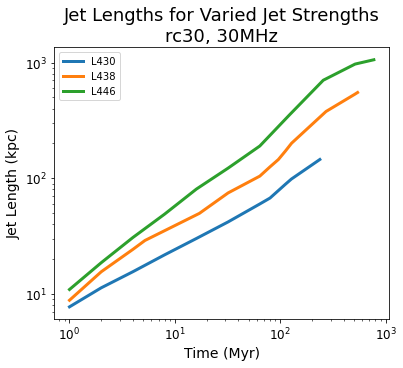

<Figure size 432x360 with 0 Axes>

In [6]:
plt.rcParams["figure.figsize"] = (6,5)

for value in strengths:
    try:
        with open("data_table_L{}.npy".format(str(value)), "rb") as open_file:
            current_freq = np.load(open_file)
            
            time_vals = []
            jet_len_vals = []

            for i in range(1, len(current_freq)):
                time_vals.append(float(current_freq[i, 0]))
                jet_len_vals.append(float(current_freq[i, 1]))
            
            plt.plot(time_vals, jet_len_vals, label="L{}".format(str(value)), linewidth=3)
        
    except:
        p = 0
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Time (Myr)", fontsize=14)
plt.ylabel("Jet Length (kpc)", fontsize=14)
plt.title("Jet Lengths for Varied Jet Strengths\nrc30, 30MHz", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc=2, prop={'size': 10})
plt.show()
plt.savefig('Jet_Lengths_vs_Time.png')

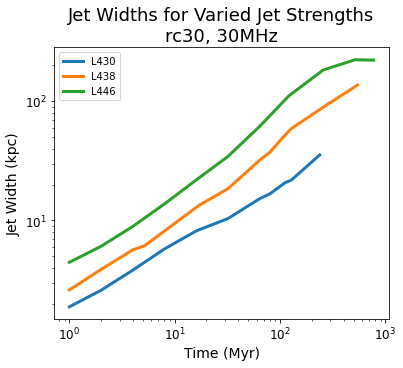

<Figure size 432x360 with 0 Axes>

In [27]:
for value in strengths:
    try:
        with open("data_table_L{}.npy".format(str(value)), "rb") as open_file:
            current_freq = np.load(open_file)
            
            time_vals = []
            jet_wid_vals = []

            for i in range(1, len(current_freq)):
                time_vals.append(float(current_freq[i, 0]))
                jet_wid_vals.append(float(current_freq[i, 2]))
            
            plt.plot(time_vals, jet_wid_vals, label="L{}".format(str(value)), linewidth=3)
        
    except:
        p = 0

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Time (Myr)", fontsize=14)
plt.ylabel("Jet Width (kpc)", fontsize=14)
plt.title("Jet Widths for Varied Jet Strengths\nrc30, 30MHz", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc=2, prop={'size': 10})
plt.show()
plt.savefig('Jet_Widths_vs_Time.png')

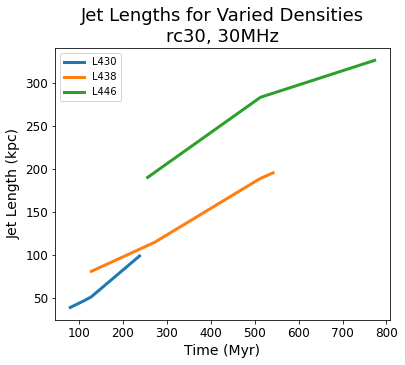

<Figure size 432x360 with 0 Axes>

In [28]:
plt.rcParams["figure.figsize"] = (6,5)


for value in strengths:
        with open("data_table_L{}.npy".format(str(value)), "rb") as open_file:
            current_freq = np.load(open_file)
            
            time_vals = []
            lobe_vals = []

            for i in range(1, len(current_freq)):
                lobe_dist = float(current_freq[i, 3])
                if lobe_dist != 0:
                    
                    time_vals.append(float(current_freq[i, 0]))
                    lobe_vals.append(lobe_dist)
                    
                    
                    
                prev_time = float(current_freq[i, 0])
                prev_lobe = lobe_dist
                    

            
            plt.plot(time_vals, lobe_vals, label="L{}".format(str(value)), linewidth=3)
        
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Time (Myr)", fontsize=14)
plt.ylabel("Jet Length (kpc)", fontsize=14)
plt.title("Jet Lengths for Varied Densities\nrc30, 30MHz", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc=2, prop={'size': 10})
plt.show()
plt.savefig('Jet_Lengths_vs_Time.png')

In [8]:
#Main Calling Block of Code

print("\nJET LENGTH AND WIDTH DETERMINING PROGRAM:")
print("{}\n".format("_"*100))

rc_vals = [3, 10, 30, 100]
nu_count = 0

for value in rc_vals: 
    path = '**/Group_L438_rc{}_*nu=30.0*0.00_1.00_0.00*Myr.fits*'.format(value)
    nu_count += 1

    # Determines if there are any files in device
    total_files = len(glob.glob(path, recursive=True))

    if total_files > 0:
        
        print("\nTRYING DENSITY RC{}...".format(str(value)))
        file_count = 0
        progress(file_count, total_files)
        jet_dim_data = np.array([["Time (Myr)", "Jet Length (kpc)", "Jet Width (kpc)", "Lobe Distance (kpc)"]])

        for file in sorted(glob.glob(path, recursive=True)):

            file_count += 1

            try:
                fits_image_hdul = fits.open(file)

                #Displays FITS Image title, time index, and pixel size
                sim_title = fits_image_hdul[0].header['OBJECT']
                nu_value = int(sim_title[-7:-4])
                sim_time = fits_image_hdul[0].header['TIME']
                sim_time = round(float(sim_time[:-4]), 1)
                pixel = fits_image_hdul[0].header['CDELT1']
                pixel_size = float(pixel[:-3])

                #Difines Data From FITS image and records image dimensions
                data =  fits_image_hdul[0].data
                length = len(data[0])
                width = len(data)

                #Calls jet_length function
                jet_len_info = jet_length(data, pixel_size)
                jet_len = jet_len_info[0]
                lobe_dist_kpc = jet_len_info[1]

                #Calls jet_width function
                jet_wid = jet_width(data, width, pixel_size)


                file_data = np.array([float(sim_time), jet_len, jet_wid, lobe_dist_kpc])
                jet_dim_data = np.vstack([jet_dim_data, file_data])
                
                progress(file_count, total_files)

            except OSError:
                print("Error with file: {}".format(file))
                print("Empty or corrupt FITS file")

        print("\n\n TABLE OF JET LENGTHS AND WIDTHS OVER TIME FOR L{}".format(str(value)))
        data_table = pd.DataFrame(jet_dim_data)
        
        
        print(data_table)
        with open("data_table_rc{}.npy".format(str(value)), "wb") as open_file:
            np.save(open_file, jet_dim_data)
        


JET LENGTH AND WIDTH DETERMINING PROGRAM:
____________________________________________________________________________________________________


TRYING DENSITY RC3...
	Files Completed: 11/11

 TABLE OF JET LENGTHS AND WIDTHS OVER TIME FOR L3
             0                 1                2                    3
0   Time (Myr)  Jet Length (kpc)  Jet Width (kpc)  Lobe Distance (kpc)
1        1e+00           13.3632           2.6075                  0.0
2        2e+00           32.5698          10.3705                  0.0
3        4e+00           74.2836          13.2997                  0.0
4        8e+00          138.2911          23.0215                  0.0
5      1.2e+01          193.6366          35.8106                  0.0
6      1.4e+01          228.9611          40.3477                  0.0
7      1.6e+01          281.9478          44.2366              97.8715
8      3.2e+01          413.6855          79.2371             114.7236
9      6.4e+01          539.2657          116.3

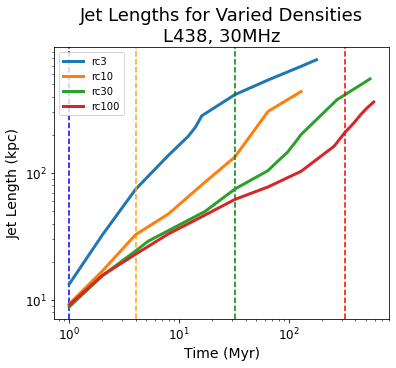

<Figure size 432x360 with 0 Axes>

In [9]:
plt.rcParams["figure.figsize"] = (6,5)

rc_colors = {3:"b", 10:"orange", 30:"green", 100:"red"}

for value in rc_vals:
        rc_met = False
        with open("data_table_rc{}.npy".format(str(value)), "rb") as open_file:
            current_freq = np.load(open_file)
            
            time_vals = []
            jet_len_vals = []

            for i in range(1, len(current_freq)):
                if float(current_freq[i, 1]) != 0:
                    if (float(current_freq[i, 1])/2) >= float(value) and rc_met is False:
                        
                        plt.axvline(x=float(current_freq[i, 0]), color=rc_colors[value], linestyle='dashed')
                        time_vals.append(float(current_freq[i, 0]))
                        jet_len_vals.append(float(current_freq[i, 1]))
                        rc_met = True
                    else:
                        time_vals.append(float(current_freq[i, 0]))
                        jet_len_vals.append(float(current_freq[i, 1]))
            
            plt.plot(time_vals, jet_len_vals, label="rc{}".format(str(value)), linewidth=3)
        
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Time (Myr)", fontsize=14)
plt.ylabel("Jet Length (kpc)", fontsize=14)
plt.title("Jet Lengths for Varied Densities\nL438, 30MHz", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc=2, prop={'size': 10})
plt.show()
plt.savefig('Jet_Lengths_vs_Time.png')

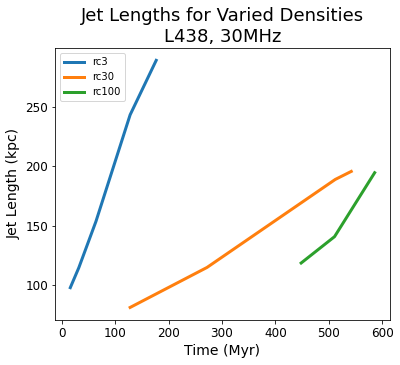

<Figure size 432x360 with 0 Axes>

In [23]:
plt.rcParams["figure.figsize"] = (6,5)

rc_colors = {3:"b", 10:"orange", 30:"green", 100:"red"}
rc_vals2 = [3, 30, 100]
for value in rc_vals2:

        with open("data_table_rc{}.npy".format(str(value)), "rb") as open_file:
            current_freq = np.load(open_file)
            
            time_vals = []
            lobe_vals = []

            for i in range(1, len(current_freq)):
                lobe_dist = float(current_freq[i, 3])
                if lobe_dist != 0:
                    
                    time_vals.append(float(current_freq[i, 0]))
                    lobe_vals.append(lobe_dist)
                    
                    
                    
                prev_time = float(current_freq[i, 0])
                prev_lobe = lobe_dist
                    

            
            plt.plot(time_vals, lobe_vals, label="rc{}".format(str(value)), linewidth=3)
        
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Time (Myr)", fontsize=14)
plt.ylabel("Jet Length (kpc)", fontsize=14)
plt.title("Jet Lengths for Varied Densities\nL438, 30MHz", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc=2, prop={'size': 10})
plt.show()
plt.savefig('Jet_Lengths_vs_Time.png')